# Sentiment anlysis on twitter dataset

## Problem Statement
Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

### What our datset contains
Dataset contains approx 7000 records with sentiment label
This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell


In [97]:
# !pip install emoji

In [98]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

In [99]:
train  = pd.read_csv('file/train.csv')

In [100]:
test = pd.read_csv('file/test.csv')

In [101]:
train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


In [102]:
train.shape

(7274, 3)

In [103]:
train.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

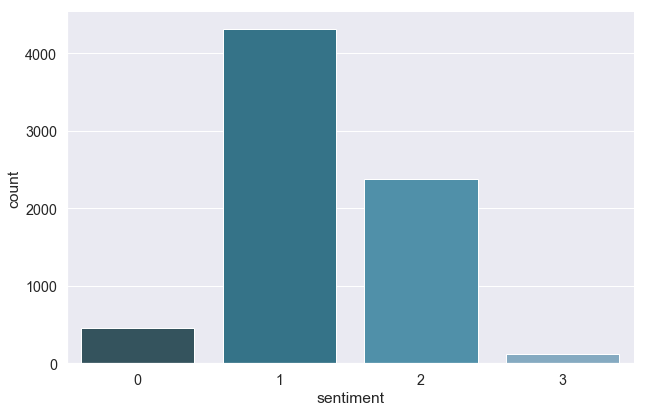

In [104]:
target_dist = sns.factorplot(x="sentiment", data=train, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();
target_dist.savefig('target_dist.png')

In [105]:
train.dropna(inplace=True)

In [106]:
# Drop the sentiment 'Can't Tell since it is not as important being less in count and also does not help in training the data 
train.drop(train[train['sentiment']==3].index,inplace=True)

In [107]:
train.drop(['tweet_id'],axis=1,inplace=True)

In [108]:
train.shape

(7148, 2)

In [109]:
train[train['sentiment']==3]

,tweet,sentiment


## A) Feature Extraction & analysis

#### Text variable

To analyze the text variable we create a class TextCounts. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

count_words : number of words in the tweet

count_mentions : referrals to other Twitter accounts, which are preceded by a @

count_hashtags : number of tag words, preceded by a #

count_capital_words : number of uppercase words, could be used to "shout" and express (negative) emotions

count_excl_quest_marks : number of question or exclamation marks

count_urls : number of links in the tweet, preceded by http(s)

count_emojis : number of emoji, which might be a good indication of the sentiment

In [110]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        train = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return train

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7148 entries, 0 to 7273
Data columns (total 2 columns):
tweet        7148 non-null object
sentiment    7148 non-null int64
dtypes: int64(1), object(1)
memory usage: 167.5+ KB


In [112]:
tc = TextCounts()

df_eda = tc.fit_transform(train['tweet'].astype(str))

df_eda['sentiment'] = train.sentiment

In [135]:
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text
0,12,0,3,0,0,0,0,1,sswnui ssw appl defin languag touch differ dialect becom smaller
1,19,0,2,0,1,0,0,1,learn ab googl doodl doodl light funni amp innov ecept signific occas googledoodl ssw
2,26,1,1,2,0,0,0,2,one face steal show yr rt quot sxsw appl school mkt epert quot link
3,20,0,3,1,0,0,0,0,iphon sxsw app would pretti awesom crash everi etend brows fuckit illmakeitwork
4,14,0,1,1,0,0,0,1,line outsid appl store austin wait new ipad sxsw link


In [114]:
df_eda['sentiment'].value_counts()

1    4310
2    2382
0    456 
Name: sentiment, dtype: int64

In [115]:
def show_dist(train, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(train.groupby('sentiment')[col].describe())
    bins = np.arange(train[col].min(), train[col].max() + 1)
    g = sns.FacetGrid(train, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    g.savefig(col + '_dist.png')

Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          456.0   19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4310.0  18.045012  5.223198  2.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0


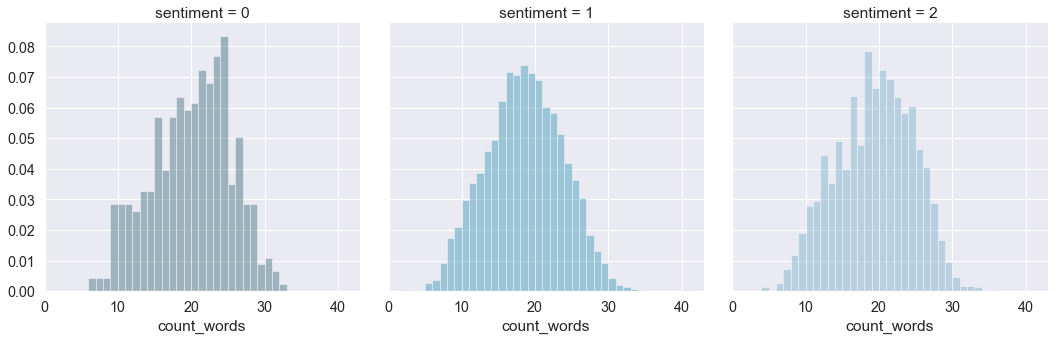

In [116]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4310.0  0.850348  0.976455  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0


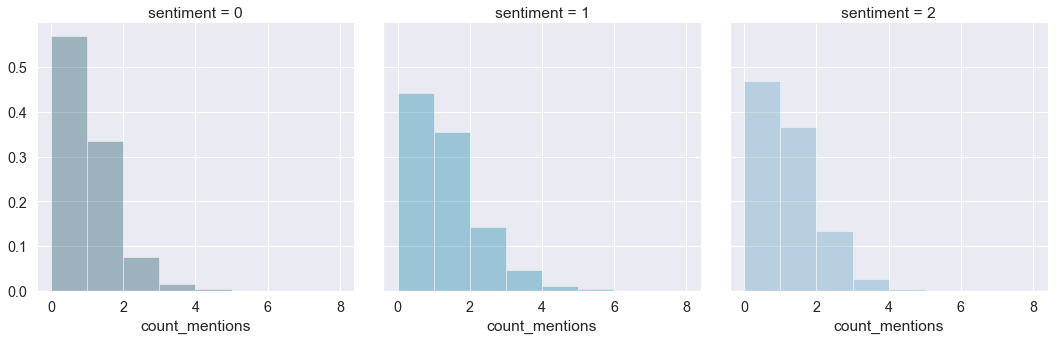

In [117]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   1.605263  0.839868  1.0  1.0  1.0  2.0  6.0 
1          4310.0  1.792575  1.180463  0.0  1.0  1.0  2.0  12.0
2          2382.0  1.683039  0.952835  0.0  1.0  1.0  2.0  7.0 


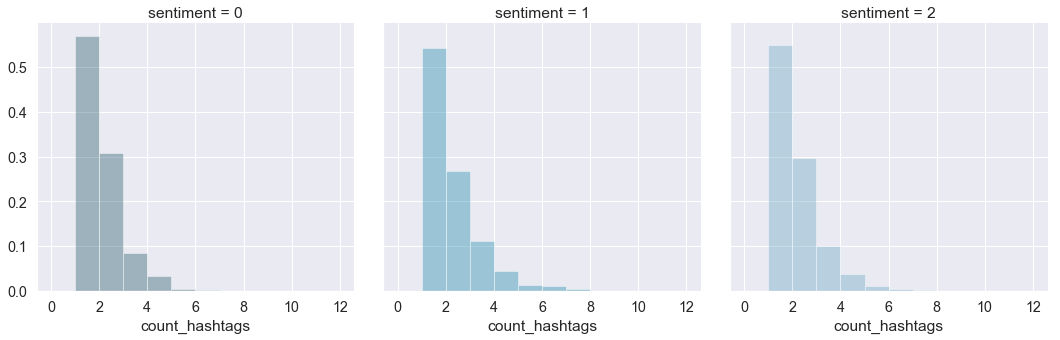

In [118]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.901316  1.199413  0.0  0.0  1.0  1.0  18.0
1          4310.0  1.110209  1.060554  0.0  0.0  1.0  2.0  17.0
2          2382.0  1.033165  0.963940  0.0  0.0  1.0  2.0  6.0 


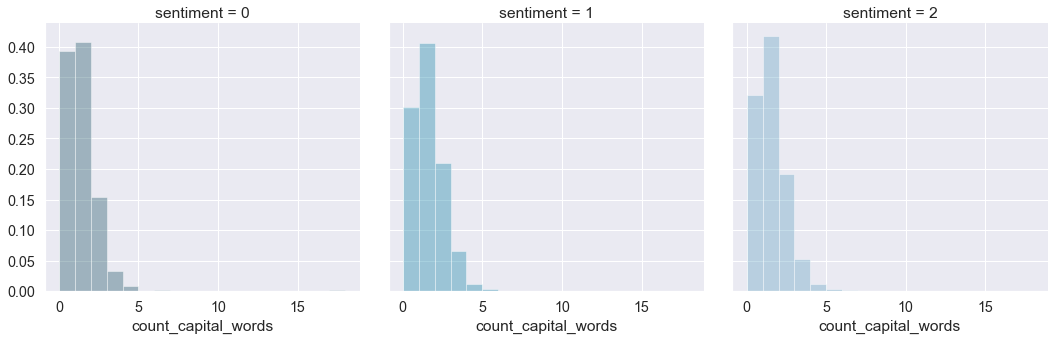

In [119]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.361842  0.819134  0.0  0.0  0.0  0.0  8.0 
1          4310.0  0.406265  0.767710  0.0  0.0  0.0  1.0  11.0
2          2382.0  0.548699  0.903084  0.0  0.0  0.0  1.0  9.0 


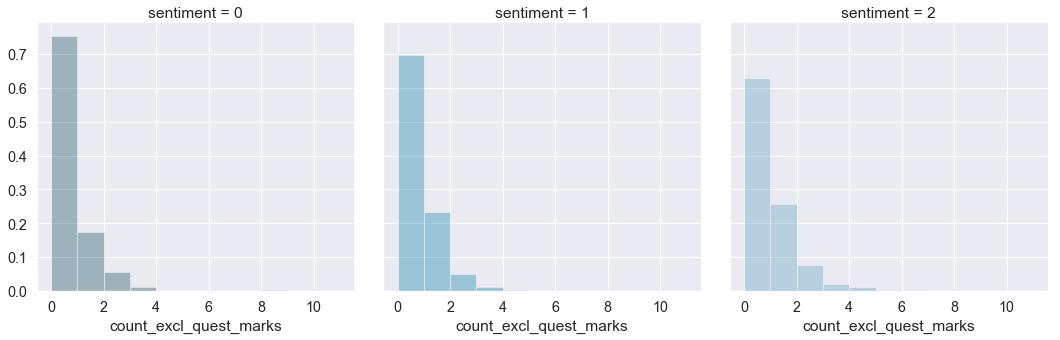

In [120]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.004618  0.067813  0.0  0.0  0.0  0.0  1.0


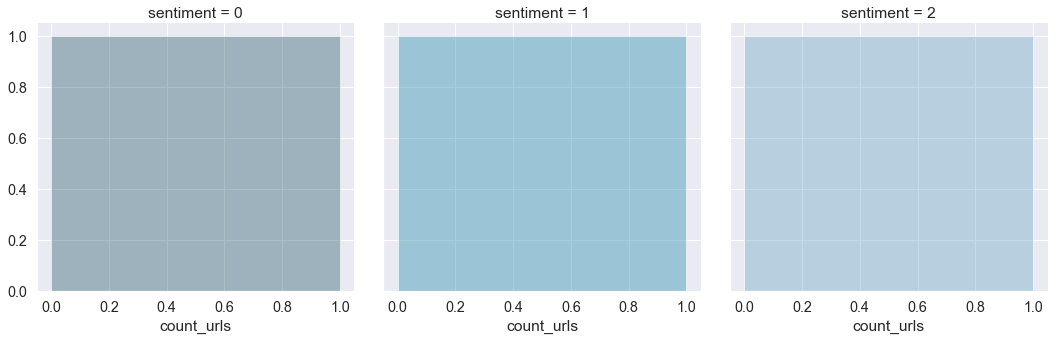

In [121]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.001259  0.035474  0.0  0.0  0.0  0.0  1.0


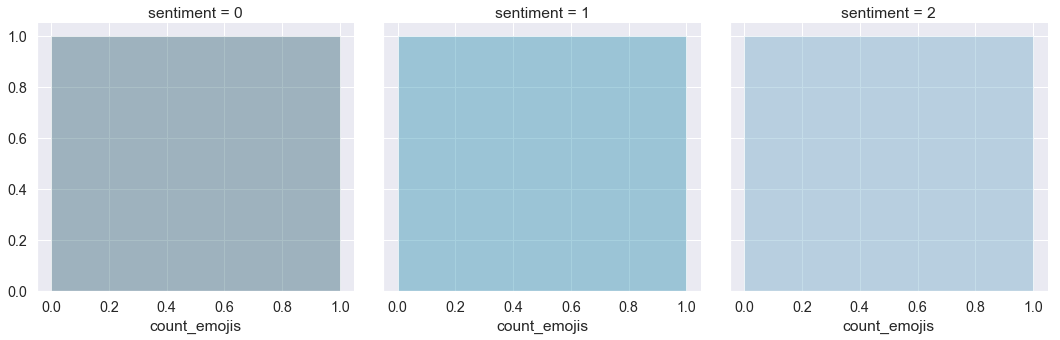

In [122]:
show_dist(df_eda, 'count_emojis')

#### CONCLUSIONS:

1) The number of words used in the tweets is rater low. Maximum number of words is 41 and there are even tweets with only 2 words. So we'll have to be careful during data cleaning not to remove too many words. On the other hand, the text processing will be faster. Negative tweets contain more words than neutral or positive tweets.

2) All tweets have at least one mention. Probably this is the result of extracting the tweets based on mentions in the Twitter data. There seems to be no difference in number of mentions with regard to the sentiment.

3) Most of the tweets do not contain hash tags. So probably this variable will not be retained during model training. Again, no difference in number of hash tags with regard to the sentiment.

4) Most of the tweets do not contain capitalized words and we do not see a difference in distribution between the sentiments.

5) The positive tweets seem to be using a bit more exclamation or question marks.

6) Most tweets do not contain a URL.

7) Most tweets do not use emojis.

#### Text Cleaning
Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:

remove the mentions, as we want to make the model generalisable to tweets of other airline companies too.

remove the hash tag sign (#) but not the actual tag as this may contain information

set all words to lowercase

remove all punctuations, including the question and exclamation marks

remove the urls as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes

make sure the converted emojis are kept as one word.

remove digits

remove stopwords- apply the PorterStemmer to keep the stem of the words

In [123]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def removing_specialCharacters(self, text):
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('\w*\d\w*', '', text)
        text = re.sub(r'[xx]*', '',text)
        text = re.sub(r'\b\w\b','',text)
        text = re.sub(r'//','',text)
        text = re.sub(r'^\s+|\s$','',text)
        text = re.sub(r'\s+',' ',text)
        text = re.sub('[^a-zA-Z#]', ' ', text) #removing special characters
        text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text) # removing duplicate words
        return text
    
    def remove_accents(self, text):
        text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore')
        return text.decode("utf-8")
        
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.removing_specialCharacters).apply(self.remove_accents).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [124]:
ct = CleanText()
sr_clean = ct.fit_transform(train['tweet'].astype(str))
sr_clean.sample(5)

5655    takin mic touchingstori ipad tablet sxsw quot ipad chang industri quot rock roll brother
4493    huge shout gsdm amp googl kick ass parti tonight unbeliev time sxsw                     
2124    see appl open temporari store sxsw ipad launch mayb transfer                            
5258    barri diller think ipad content nut sxsw link                                           
22      gt gt googl launch major new social network call circl possibl today link ssw           
Name: tweet, dtype: object

In [125]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


Now that we have the cleaned text of the tweets, we can have a look at what are the most frequent words. Below we'll show the top 20 words

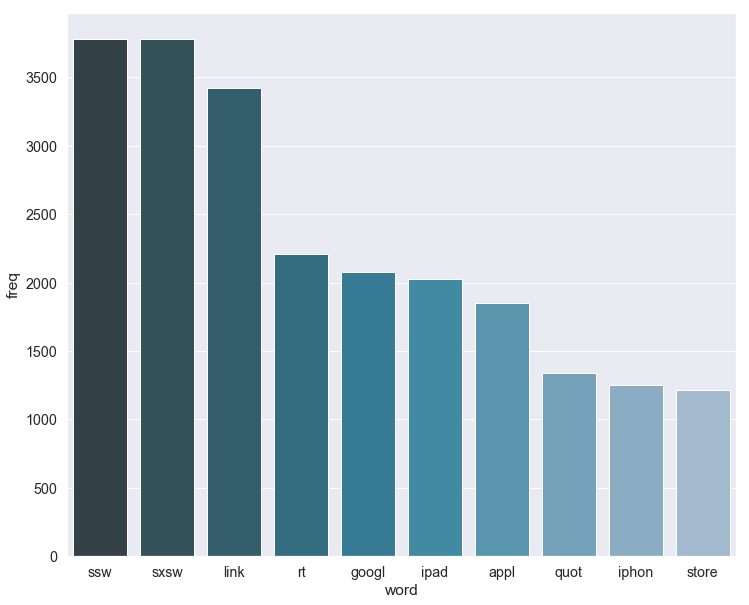

In [126]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();
bar_freq_word.get_figure().savefig('bar_freq_word.png')

In [127]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'sentiment',
 'clean_text']

In [128]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [129]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('sentiment', axis=1), df_model.sentiment, test_size=0.25, random_state=42)

In [130]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search


#### Parameter grids for GridSearchCV

In [131]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Parameter grid settings for SVC
parameters_svc = {
    'clf__C': (0.25, 0.5, 1.0,1.5)
}

#### CLassifiers

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score,classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC
mnb = MultinomialNB()
logreg = LogisticRegression()
svc = LinearSVC(random_state=42)

In [133]:
countvect = CountVectorizer()

In [134]:
#MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   25.4s finished


done in 26.461s

Best CV score: 0.666
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.670


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.71      0.14      0.23       123
           1       0.70      0.83      0.76      1077
           2       0.58      0.49      0.53       587

    accuracy                           0.67      1787
   macro avg       0.66      0.49      0.51      1787
weighted avg       0.66      0.67      0.65      1787



In [86]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished


done in 92.416s

Best CV score: 0.689
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.693


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.53      0.15      0.23       123
           1       0.72      0.87      0.78      1077
           2       0.64      0.49      0.55       587

    accuracy                           0.69      1787
   macro avg       0.63      0.50      0.52      1787
weighted avg       0.68      0.69      0.67      1787



In [87]:
## Applying SVC
best_svc_countvect = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0, 1.5),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.5min finished


done in 210.413s

Best CV score: 0.672
Best parameters set:
	clf__C: 0.25
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.689


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.48      0.24      0.32       123
           1       0.73      0.82      0.78      1077
           2       0.61      0.53      0.57       587

    accuracy                           0.69      1787
   macro avg       0.61      0.53      0.56      1787
weighted avg       0.68      0.69      0.68      1787



# Applying TF-IDF

In [88]:
tfidfvect = TfidfVectorizer()

In [90]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.2min finished


done in 70.235s

Best CV score: 0.672
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.680


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.38      0.02      0.05       123
           1       0.69      0.90      0.79      1077
           2       0.63      0.41      0.50       587

    accuracy                           0.68      1787
   macro avg       0.57      0.44      0.44      1787
weighted avg       0.65      0.68      0.64      1787



In [91]:
# SVC
best_svc_tfidf = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0, 1.5),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.1min finished


done in 250.574s

Best CV score: 0.688
Best parameters set:
	clf__C: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.698


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.63      0.18      0.28       123
           1       0.73      0.85      0.78      1077
           2       0.62      0.54      0.58       587

    accuracy                           0.70      1787
   macro avg       0.66      0.52      0.55      1787
weighted avg       0.69      0.70      0.68      1787



In [92]:
# MNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.1s finished


done in 19.816s

Best CV score: 0.663
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.670


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.70      0.06      0.11       123
           1       0.69      0.87      0.77      1077
           2       0.60      0.43      0.50       587

    accuracy                           0.67      1787
   macro avg       0.66      0.45      0.46      1787
weighted avg       0.66      0.67      0.64      1787



# BEST MODEL SELECTED IS :- SVC with Count Vectorization

## Applying the model in test

In [94]:

textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', TfidfVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf',LinearSVC(C=0.5))
])

best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)


In [95]:
df_counts_pos = tc.transform(test['tweet'].astype(str))
df_clean_pos = ct.transform(test['tweet'].astype(str))
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

y_pred = best_model.predict(df_model_pos).tolist()

In [96]:
def savesubmissionfile(y_pred,df):
    d =dict(zip(list(df['tweet_id']),list(y_pred)))
    submission =pd.DataFrame(d.items(),columns =['tweet_id','sentiment'])
    submission.set_index(drop=True,inplace=True,keys='tweet_id')
    return submission

In [97]:
submission = savesubmissionfile(y_pred,test)

In [98]:
submission['sentiment'].value_counts()

1    1254
2    520 
0    45  
Name: sentiment, dtype: int64

In [99]:
submission.to_csv('Submission_10_SVC_tfidf.csv')

In [100]:
import os

In [103]:
os.getcwd()

'/Users/priyanka/Desktop/Hackathon#3/Final'